In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import sys
import seaborn as sns
from matplotlib import cm
import scipy

## Read epitope data

In [2]:
## Read epitope data
# path_to_epitope_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/epitope_table_export_1640110271.csv"
path_to_epitope_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/MHCI/epitope_table_export_1640338769.csv"
epitope_raw_df = pd.read_csv(path_to_epitope_file,skiprows=1)
epitope_raw_df = epitope_raw_df[['Epitope ID',"Description","Antigen Name"]]
## Read experiment data
# path_to_experiment_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/tcell_table_export_1640110603.csv"
path_to_experiment_file = "/Users/christianpederjacobsen/Dropbox/Mac/Desktop/leg/peptide_immunogenicity/data/MHCI/tcell_table_export_1640338787.csv"
experiment_raw_df = pd.read_csv(path_to_experiment_file,skiprows=1)
experiment_raw_df = experiment_raw_df[['Epitope ID',"Cell Type","Allele Name","Antigen Description","Qualitative Measure","Assay Group","Number of Subjects Tested","Number of Subjects Responded"]].dropna()
experiment_raw_df = experiment_raw_df[experiment_raw_df["Number of Subjects Tested"] > 0]
experiment_raw_df.sort_values(by='Epitope ID', ascending=True)

/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_19718/2938309479.py:9: DtypeWarning: Columns (5,14,22,23,24,27,28,29,30,31,32,35,36,38,39,45,46,47,48,52,53,54,55,56,57,61,62,63,64,65,67,68,69,70,71,72,73,74,75,76,77,78,81,82,83,86,88,96,97,116) have mixed types. Specify dtype option on import or set low_memory=False.
  experiment_raw_df = pd.read_csv(path_to_experiment_file,skiprows=1)


,Epitope ID,Cell Type,Allele Name,Antigen Description,Qualitative Measure,Assay Group,Number of Subjects Tested,Number of Subjects Responded
188,10,T cell CD8+,HLA-B*51:01,AAAAAIFVI,Positive,IFNg release,14.0,4.0
93,10,T cell CD8+,HLA-B*51:01,AAAAAIFVI,Positive,cytotoxicity,3.0,3.0
41368,10,T cell CD8+,HLA-B*51:01,AAAAAIFVI,Negative,IFNg release,15.0,0.0
41369,10,T cell CD8+,HLA-B*51:01,MHC class I related protein A,Positive,IFNg release,3.0,3.0
1782,39,T cell CD8+,HLA class I,AAAIFMTATPPGTAD,Negative,IFNg release,15.0,0.0
...,...,...,...,...,...,...,...,...
76822,1707900,T cell CD8+,HLA-A*02:01,WLTYTGAIKL,Positive,IFNg release,3.0,1.0
77001,1709065,T cell CD8+,HLA-A*24:02,YFNKKDWYDF,Negative,IFNg release,3.0,0.0
76791,1709453,T cell CD8+,HLA-A*02:06,YIIKLIFLWL,Negative,IFNg release,3.0,0.0
76812,1711481,T cell CD8+,HLA-A*33:03,YYKLGASQR,Positive,IFNg release,3.0,1.0


In [4]:
experiment_raw_df.to_excel("tmp_out.xlsx")

## What types of HLA alleles is found in the dataset?

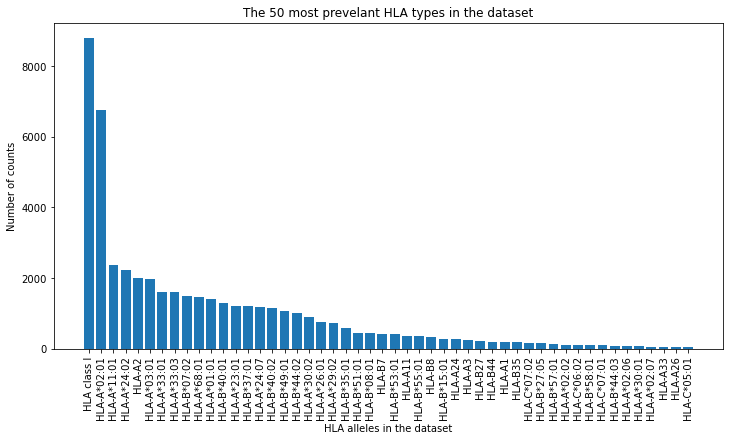

In [4]:
def show_HLA_dist(experiment_data):
    unique, counts = np.unique(experiment_data["Allele Name"],return_counts=True)
    count_dict = {allele:count for (allele,count) in zip(unique, counts)}
    unique = sorted(unique,key=lambda x: count_dict[x],reverse=True)
    counts = [count_dict[x] for x in unique]

    N = 50
    fig = plt.figure(figsize=(12,6))
    plt.bar(np.arange(N),counts[:N])
    plt.xticks(np.arange(N),unique[:N],rotation=90)
    plt.title("The 50 most prevelant HLA types in the dataset")
    plt.xlabel("HLA alleles in the dataset")
    plt.ylabel("Number of counts")
    plt.show()
show_HLA_dist(experiment_raw_df)


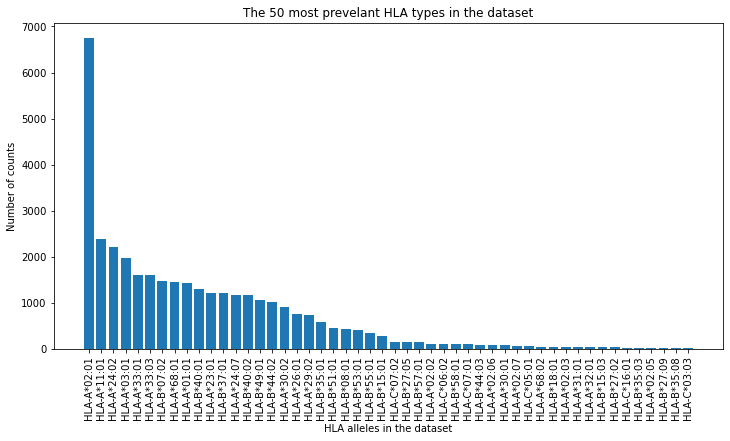

In [5]:
# Fitler based on a specific HLA alelle
alleles = ["*" in x for x in experiment_raw_df["Allele Name"]]
experiment_data = experiment_raw_df[alleles]
show_HLA_dist(experiment_data)


/var/folders/px/wpqhk62d559gjgm0ql254vq00000gn/T/ipykernel_8780/3777267136.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experiment_data["epitope_length"] = experiment_data["Antigen Description"].apply(lambda x: len(x.strip()))


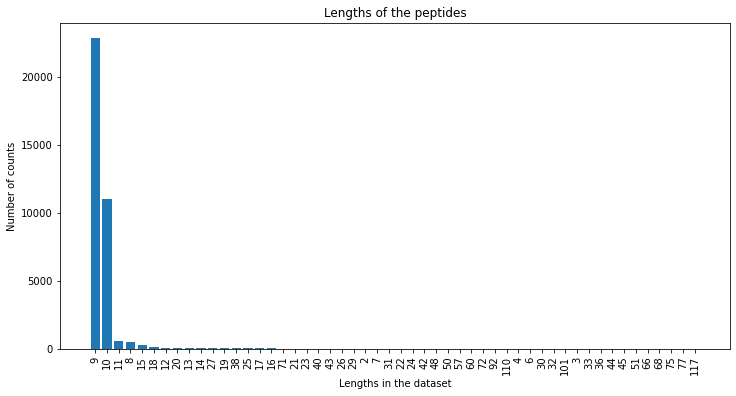

In [6]:
def show_peptide_lengths(experiment_data):
    ## Filter based on epitope length
    unique, counts = np.unique(experiment_data["epitope_length"],return_counts=True)
    count_dict = {allele:count for (allele,count) in zip(unique, counts)}
    unique = sorted(unique,key=lambda x: count_dict[x],reverse=True)
    counts = [count_dict[x] for x in unique]

    fig = plt.figure(figsize=(12,6))
    plt.bar(np.arange(len(counts)),counts)
    plt.xticks(np.arange(len(unique)),unique,rotation=90)
    plt.title("Lengths of the peptides")
    plt.xlabel("Lengths in the dataset")
    plt.ylabel("Number of counts")
    plt.show()



epitope_ids,counts = np.unique(experiment_data["Epitope ID"],return_counts=True)
experiment_data["epitope_length"] = experiment_data["Antigen Description"].apply(lambda x: len(x.strip()))
show_peptide_lengths(experiment_data)
filter_lengths = [9,10]
experiment_data = experiment_data[experiment_data.epitope_length.isin(filter_lengths)]



In [7]:
duplication = set()
outfile = open("lort.txt","w+")
i = 0 
for index,row in experiment_data.iterrows():
    if row["Epitope ID"] not in duplication:
        print(">{}".format(row["Epitope ID"]),file=outfile)
        print(row["Antigen Description"],file=outfile)
    duplication.add(row["Epitope ID"])
    i += 1
outfile.close()


# Filter peptides

In [8]:
def Intersection(lst1, lst2):
    return set(lst1).intersection(lst2)

filterchars = list("x123456789 \t!?")


non_filtered = [len(Intersection(filterchars, list(x.lower()))) == 0  for x in experiment_data["Antigen Description"]]
non_filtered
experiment_data = experiment_data[non_filtered]
# experiment_data

## Encoding peptides

In [9]:
def onehot_encode_peptide(peptide):
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    encoded_peptide = pd.Series(list(peptide))
    encoded_peptide = encoded_peptide.astype(pd.CategoricalDtype(categories=aminoacids))
    encoded_peptide = pd.get_dummies(encoded_peptide)
    return encoded_peptide.to_numpy()

def categorical_encode_peptide(peptide):
    aminoacids = ["A","R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]
    encoded_peptide = np.array([aminoacids.index(x)+1 for x in list(peptide)])
    return encoded_peptide



N,M = experiment_data.shape
X = []
onehot = []
categorical = []
aims_features = []
for i in range(N):
    peptide = experiment_data.iloc[i]["Antigen Description"]
    # One-hot encoding
    one_hot_encoded_peptide = onehot_encode_peptide(peptide)
    onehot.append(one_hot_encoded_peptide.reshape(-1,))
    # Categorical encoding
    categorical_encoded_peptide = categorical_encode_peptide(peptide)
    categorical.append(categorical_encoded_peptide.reshape(-1,))

experiment_data["categorical"] = categorical
experiment_data["onehot"] = onehot

In [12]:
onehot[0].shape

(180,)

In [31]:
X_onehot = experiment_data["onehot"].to_numpy()
longest = 20*10


for i,row in enumerate(X_onehot):
    if len(row) != longest:
        padding_len = longest - len(row)
        padding = np.zeros(padding_len)
        padded_row = np.concatenate((padding,row))
        X_onehot[i] = padded_row

X_onehot = np.vstack(X_onehot).astype(float)
# N,M = X_onehot.shape
X_onehot.shape

(33807, 200)

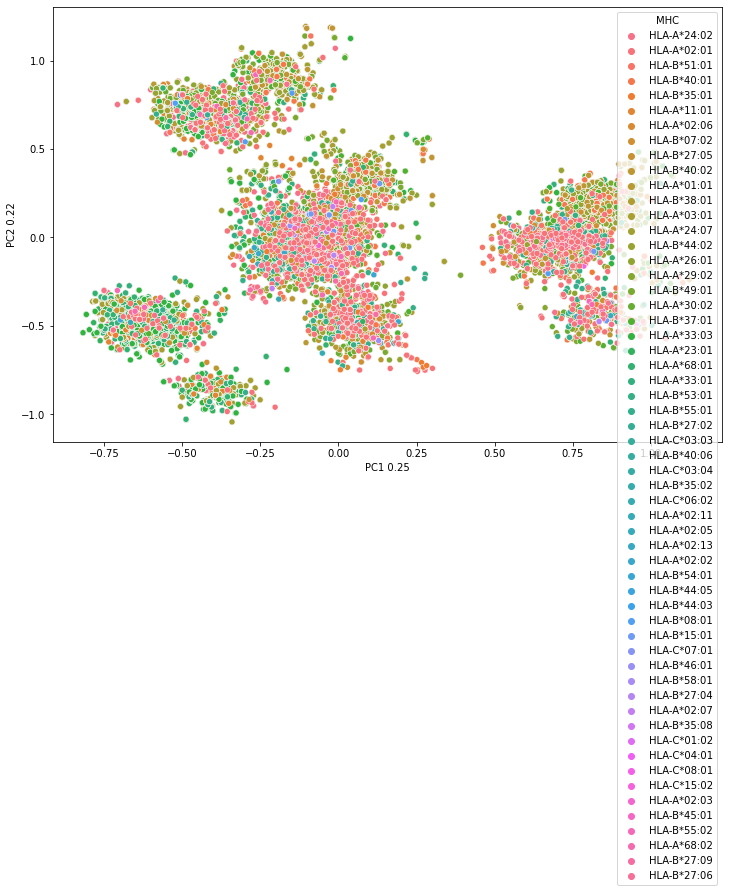

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_onehot)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf["MHC"] = experiment_data["Allele Name"]
# principalDf.loc[principalDf['immunogenecity'] <= 0.1, 'immunogenecity'] = 0
# principalDf.loc[principalDf['immunogenecity'] > 0.1, 'immunogenecity'] = 1
pc1_var, pc2_var = pca.explained_variance_
fig = plt.figure(figsize=(12,8))
sns.scatterplot(data=principalDf, x="principal component 1", y="principal component 2",hue="MHC")
plt.xlabel(f"PC1 {round(pc1_var,2)}")
plt.ylabel(f"PC2 {round(pc2_var,2)}")

plt.show()

# Applying different clustering strategies

In [ ]:
from sklearn.cluster import Birch
from matplotlib import pyplot

Text(0, 0.5, 'PC2 0.28')

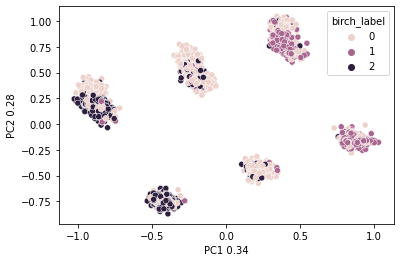

In [ ]:
model = Birch(threshold=0.01, n_clusters=3)
model.fit(X_onehot)
birch_predictions = model.predict(X_onehot)
principalDf["birch_label"] = birch_predictions
sns.scatterplot(data=principalDf, x="principal component 1", y="principal component 2",hue="birch_label")
plt.xlabel(f"PC1 {round(pc1_var,2)}")
plt.ylabel(f"PC2 {round(pc2_var,2)}")

2.1


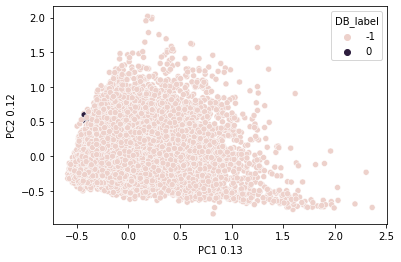

2.6


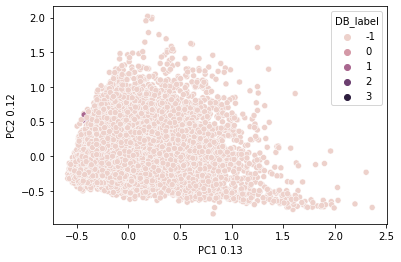

3.1


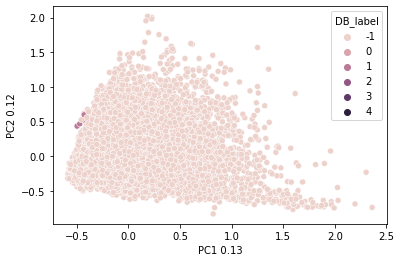

3.6


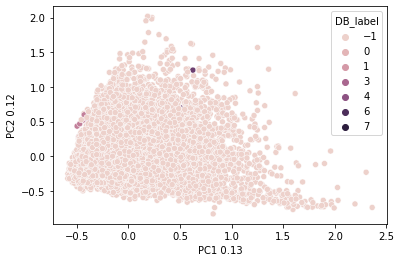

In [ ]:
from sklearn.cluster import DBSCAN
for i in range(1,20,5):
    eps = 2 + 0.1*i
    print(eps)
    model_2 = DBSCAN(eps=eps, min_samples=10)
    DB_scan_predictions = model_2.fit_predict(X_r)
    finalDf["DB_label"] = DB_scan_predictions
    sns.scatterplot(data=finalDf, x="principal component 1", y="principal component 2",hue="DB_label")
    plt.xlabel(f"PC1 {round(pc1_var,2)}")
    plt.ylabel(f"PC2 {round(pc2_var,2)}")
    plt.show()

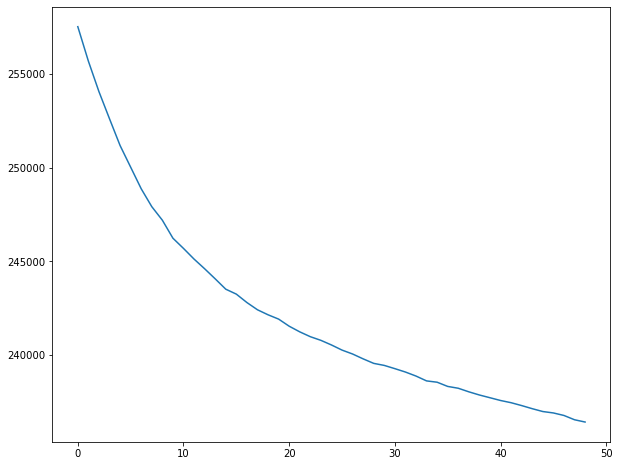

In [ ]:
from sklearn.cluster import KMeans
intertia = []
for i in range(1,50):
    # define the model
    model_3 = KMeans(n_clusters=i)
    # fit the model_3
    model_3.fit(X_r)
    # assign a cluster to each example
    predictions = model_3.predict(X_r)
    # retrieve unique clusters
    intertia.append(model_3.inertia_)

fig = plt.figure(figsize=(10,8))
plt.plot(np.arange(len(intertia)),intertia)
plt.show()